<a href="https://colab.research.google.com/github/Oreolorun/Image-Recognition/blob/main/CarTypeImageRegcognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  importing libraries 
import os
import numpy as np
import torch
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import pandas as pd
!pip install shap
import shap

In [2]:
#  mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the CPU


In [22]:
#  loading and labelling data

class LoadVehicleData():
  def __init__(self):
    self.sedans = 'gdrive/My Drive/Datasets/Car_Images/test_images/test_sedans'
    self.coupes = 'gdrive/My Drive/Datasets/Car_Images/test_images/test_coupes'
    self.suvs = 'gdrive/My Drive/Datasets/Car_Images/test_images/test_suvs'
    self.trucks = 'gdrive/My Drive/Datasets/Car_Images/test_images/test_trucks'
    self.labels = {self.sedans:0, self.coupes:1, self.suvs:2, self.trucks:3}
    self.img_size = 75
    self.training_data = []
    self.sedan_count = 0
    self.coupe_count = 0
    self.suv_count = 0
    self.truck_count = 0

  def create_dataset(self, rebuild=True):
    if rebuild:
      for key in self.labels:
        print(key)
        for img_file in tqdm(os.listdir(key)):
          try:
            path = os.path.join(key, img_file)
            image = cv2.imread(path)
            image = cv2.resize(image, (self.img_size, self.img_size))
            image = np.array(image)
            self.training_data.append([image, int(self.labels[key])])
            if key == self.sedans:
              self.sedan_count+=1
            elif key == self.coupes:
              self.coupe_count+=1
            elif key == self.suvs:
              self.suv_count+=1
            elif key == self.trucks:
              self.truck_count+=1
          except Exception as e:
            pass

      #np.random.shuffle(self.training_data)
      np.save('gdrive/My Drive/Neural Networks/loaded_npy_files/Car75_testUS.npy', 
              self.training_data)
      print(f'\nsedan images: {self.sedan_count}')
      print(f'coupe images: {self.coupe_count}')
      print(f'suv images: {self.suv_count}')
      print(f'truck images: {self.truck_count}')
      print(f'total: {self.sedan_count + self.coupe_count + self.suv_count + self.truck_count}')
      print('All done!')
    else:
      print('Rebuild argument set to false, data will be loaded into the dataset'+ 
            ' object from specified path.\nSet rebuild to true to rebuild dataset.')
      pass

In [23]:
#  creating an instance of the class LoadVehicleData
data = LoadVehicleData()

#  creating dataset
data.create_dataset(rebuild=False)

#  loading dataset into object
#dataset = np.load('gdrive/My Drive/Neural Networks/loaded_npy_files/CarType100x100.npy', allow_pickle=True)
print('\nDone!')

gdrive/My Drive/Datasets/Car_Images/test_images/test_sedans


100%|██████████| 594/594 [00:03<00:00, 177.09it/s]


gdrive/My Drive/Datasets/Car_Images/test_images/test_coupes


100%|██████████| 591/591 [00:03<00:00, 169.36it/s]


gdrive/My Drive/Datasets/Car_Images/test_images/test_suvs


100%|██████████| 595/595 [00:03<00:00, 164.87it/s]


gdrive/My Drive/Datasets/Car_Images/test_images/test_trucks


100%|██████████| 594/594 [00:03<00:00, 156.11it/s]
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



sedan images: 594
coupe images: 591
suv images: 595
truck images: 594
total: 2374
All done!

Done!


In [4]:
#  loading test images
test_75 = np.load('gdrive/My Drive/Neural Networks/loaded_npy_files/Car75_test.npy', 
                  allow_pickle=True)

test_100 = np.load('gdrive/My Drive/Neural Networks/loaded_npy_files/Car100_test.npy', 
                  allow_pickle=True)

test_75_US = np.load('gdrive/My Drive/Neural Networks/loaded_npy_files/Car75_testUS.npy', 
                  allow_pickle=True)

test_100_US = np.load('gdrive/My Drive/Neural Networks/loaded_npy_files/Car100_testUS.npy', 
                  allow_pickle=True)

In [ ]:
#  checking dataset
len(dataset)

81332

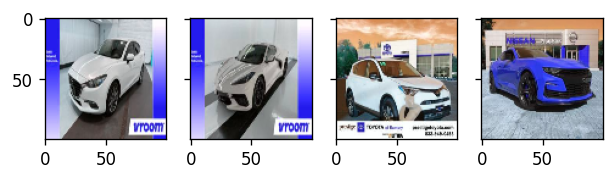

In [ ]:
#  Displaying random images
figure, axes = plt.subplots(1,4, dpi=120, sharey=True)
axes[0].imshow(dataset[2457][0])
axes[1].imshow(dataset[1][0])
axes[2].imshow(dataset[23967][0])
axes[3].imshow(dataset[19929][0])

In [ ]:
#  defining splitting function
def train_val_split(dataset_to_split, val_pct):
  #  deriving dataset length
  number_of_instances = len(dataset_to_split)
  #  deriving length of validattion set
  val_idx = int(number_of_instances*val_pct)
  #  deriving random permutations of the whole dataset
  idx = list(np.random.permutation(number_of_instances))
  return idx[:val_idx], idx[val_idx:]

#  creating testing, validation and training indices
#test_indices, dataset_indices = train_val_split(dataset, 0.1)
#val_indices, train_indices = train_val_split(dataset_indices, 0.2)

#  saving indices for reproducbility
#np.save(f'gdrive/My Drive/Neural Networks/loaded_npy_files/train_indices_{str(len(dataset))}.npy', train_indices)
#np.save(f'gdrive/My Drive/Neural Networks/loaded_npy_files/val_indices_{str(len(dataset))}.npy', val_indices)
#np.save(f'gdrive/My Drive/Neural Networks/loaded_npy_files/test_indices_{str(len(dataset))}.npy', test_indices)

#  loading saved indices
train_indices = list(np.load(f'gdrive/My Drive/Neural Networks/loaded_npy_files/train_indices_{str(len(dataset))}.npy', allow_pickle=True))
val_indices = list(np.load(f'gdrive/My Drive/Neural Networks/loaded_npy_files/val_indices_{str(len(dataset))}.npy', allow_pickle=True))
test_indices = list(np.load(f'gdrive/My Drive/Neural Networks/loaded_npy_files/test_indices_{str(len(dataset))}.npy', allow_pickle=True))

#  splitting into training, validation and test sets
training_set = dataset[train_indices]
validation_set = dataset[val_indices]
test_set = dataset[test_indices]

In [5]:
#  extending Dataset class
class VehicleDataset(Dataset):
  def __init__(self, loaded_dataset, transforms=None):
    self.loaded_dataset = loaded_dataset
    self.transforms = transforms

  def __len__(self):
    return len(self.loaded_dataset)
  
  def __getitem__(self, idx):
    #  extracting image from index and scaling
    image = self.loaded_dataset[idx][0]/255
    #  extracting label from index
    label = torch.tensor(int(self.loaded_dataset[idx][1]))
    #  applying transforms if transforms are supplied
    if self.transforms:
      image = self.transforms(image)
    return (image, label)

In [ ]:
#  creating instances of the dataset class
train_ds = VehicleDataset(training_set, transforms=transforms.ToTensor())
val_ds = VehicleDataset(validation_set, transforms=transforms.ToTensor())
test_ds = VehicleDataset(test_set, transforms=transforms.ToTensor())

#  creating dataloaders
batch_size = 100
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True) 
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [6]:
#  creating instances of the dataset class for test images
test_75_ds = VehicleDataset(test_75, transforms=transforms.ToTensor())
test_100_ds = VehicleDataset(test_100, transforms=transforms.ToTensor())
test_75_dsUS = VehicleDataset(test_75_US, transforms=transforms.ToTensor())
test_100_dsUS = VehicleDataset(test_100_US, transforms=transforms.ToTensor())

#  creating dataloaders
batch_size = 200
test_75_dl = DataLoader(test_75_ds, batch_size=batch_size)
test_100_dl = DataLoader(test_100_ds, batch_size=batch_size)
test_75_dlUS = DataLoader(test_75_dsUS, batch_size=batch_size)
test_100_dlUS = DataLoader(test_100_dsUS, batch_size=batch_size)

In [7]:
#  building neural network
class CarRecognition(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(8192, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.pool4 = nn.MaxPool2d(2,2)
    self.pool7 = nn.MaxPool2d(2,2)

  def forward(self, x):
    x = x.view(-1, 3, 100, 100).float()
    x = F.relu(self.conv1(x))
    x = self.pool2(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.pool4(F.relu(self.conv4(x)))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.pool7(F.relu(self.conv7(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

In [8]:
#  building neural network for 75px images
class CarRecognition_75(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(2048, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.pool4 = nn.MaxPool2d(2,2)
    self.pool7 = nn.MaxPool2d(2,2)

  def forward(self, x):
    x = x.view(-1, 3, 75, 75).float()
    x = F.relu(self.conv1(x))
    x = self.pool2(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.pool4(F.relu(self.conv4(x)))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.pool7(F.relu(self.conv7(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

In [9]:
#  building neural network
class CarRecognition_bn(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(8192, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.pool4 = nn.MaxPool2d(2,2)
    self.pool7 = nn.MaxPool2d(2,2)
    self.batchnorm_conv1 = nn.BatchNorm2d(32)
    self.batchnorm_conv2 = nn.BatchNorm2d(32)
    self.batchnorm_conv3 = nn.BatchNorm2d(64)
    self.batchnorm_conv4 = nn.BatchNorm2d(64)
    self.batchnorm_conv5 = nn.BatchNorm2d(128)
    self.batchnorm_conv6 = nn.BatchNorm2d(128)
    self.batchnorm_conv7 = nn.BatchNorm2d(128)
    self.batchnorm_fc1 = nn.BatchNorm1d(514)
    self.batchnorm_fc2 = nn.BatchNorm1d(128)

  def forward(self, x):
    x = x.view(-1, 3, 100, 100).float()
    x = F.relu(self.batchnorm_conv1(self.conv1(x)))
    x = self.pool2(F.relu(self.batchnorm_conv2(self.conv2(x))))
    x = F.relu(self.batchnorm_conv3(self.conv3(x)))
    x = self.pool4(F.relu(self.batchnorm_conv4(self.conv4(x))))
    x = F.relu(self.batchnorm_conv5(self.conv5(x)))
    x = F.relu(self.batchnorm_conv6(self.conv6(x)))
    x = self.pool7(F.relu(self.batchnorm_conv7(self.conv7(x))))
    x = torch.flatten(x,1)
    x = F.relu(self.batchnorm_fc1(self.fc1(x)))
    x = F.relu(self.batchnorm_fc2(self.fc2(x)))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

In [10]:
#  building neural network
class CarRecognition_bn75(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(2048, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.pool4 = nn.MaxPool2d(2,2)
    self.pool7 = nn.MaxPool2d(2,2)
    self.batchnorm_conv1 = nn.BatchNorm2d(32)
    self.batchnorm_conv2 = nn.BatchNorm2d(32)
    self.batchnorm_conv3 = nn.BatchNorm2d(64)
    self.batchnorm_conv4 = nn.BatchNorm2d(64)
    self.batchnorm_conv5 = nn.BatchNorm2d(128)
    self.batchnorm_conv6 = nn.BatchNorm2d(128)
    self.batchnorm_conv7 = nn.BatchNorm2d(128)
    self.batchnorm_fc1 = nn.BatchNorm1d(514)
    self.batchnorm_fc2 = nn.BatchNorm1d(128)

  def forward(self, x):
    x = x.view(-1, 3, 75, 75).float()
    x = F.relu(self.batchnorm_conv1(self.conv1(x)))
    x = self.pool2(F.relu(self.batchnorm_conv2(self.conv2(x))))
    x = F.relu(self.batchnorm_conv3(self.conv3(x)))
    x = self.pool4(F.relu(self.batchnorm_conv4(self.conv4(x))))
    x = F.relu(self.batchnorm_conv5(self.conv5(x)))
    x = F.relu(self.batchnorm_conv6(self.conv6(x)))
    x = self.pool7(F.relu(self.batchnorm_conv7(self.conv7(x))))
    x = torch.flatten(x,1)
    x = F.relu(self.batchnorm_fc1(self.fc1(x)))
    x = F.relu(self.batchnorm_fc2(self.fc2(x)))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

In [11]:
def accuracy(network, train_loader, verbose=False):
  """
  this function calculates accuracy
  """
  #  instantiating model state
  network.eval()
  #  creating counter for correctly classified instances
  correctly_classified = 0
  #  creating counter for all instances
  all_instances = 0

  #  looping through every batch
  for images, labels in tqdm_notebook(train_loader):
    images, labels = images.to(device), labels.to(device)
    #  classifying
    outputs = network(images)
    #  deriving the index of model prediction
    predicted_labels = torch.argmax(outputs, dim=1)
    #  comparing and counting the number of correct predictions
    correct_labels = sum(predicted_labels==labels)
    #  counting correct predictions
    correctly_classified+=correct_labels.item()
    #  counting all instances
    all_instances+=len(labels)

  if verbose:
    return print(f'[{correctly_classified}/{all_instances}]\nmodel predicts all'+ 
                 f'instances to {round((correctly_classified/all_instances)*100, 2)}% accuracy')
  else:
    return correctly_classified/all_instances

In [ ]:
def train_model(network, epochs, loss_function, opt, train_loader, val_loader):
  """
  this function trains a neural network and calculates metrics on both the
  training set and the validation set 
  """
  #  creating a list to hold metrics
  metric_log = []

  for epoch in range(epochs):
    #  instantiating model state
    network.train()

    #  training
    print(f'\nTraining Epoch {epoch+1}/{epochs}')
    total_loss = 0
    total_instances = 0
    for images, labels in tqdm_notebook(train_loader):
      #  sending to device
      images, labels = images.to(device), labels.to(device)
      #  resetting gradients
      opt.zero_grad()
      #  classifying
      outputs = network(images)
      #  computing loss
      loss = loss_function(outputs, labels)
      with torch.no_grad():
        #  summing loss
        total_loss+=loss.sum().item()
        #  summing instances
        total_instances+=len(labels)
      #  computing gradients
      loss.backward()
      #  optimizing
      opt.step()
    #  deriving training accuracy
    with torch.no_grad():
      print('Deriving training accuracy...')
      train_accuracy = accuracy(network, train_loader)

    #  deriving validation loss and accuracy
    with torch.no_grad():
      print('Deriving validation loss...')
      total_val_loss = 0
      total_val_instances = 0
      for val_images, val_labels in tqdm_notebook(val_loader):
        #  sending to device
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        #  classifying
        val_outputs = network(val_images)
        #  computing loss
        val_loss = loss_function(val_outputs, val_labels)
        #  summing val_loss
        total_val_loss+=val_loss.sum().item()
        #  summing total_val_instances
        total_val_instances+=len(val_labels)
      print('Deriving validation accuracy...')
      #  computing accuracy
      val_accuracy = accuracy(network, val_loader)
    #  appending metrics to list
    metric_log.append([epoch+1, total_loss/total_instances, 
                       train_accuracy, total_val_loss/total_val_instances, 
                       val_accuracy])
    
    #  displaying results
    print(f'Epoch: {epoch+1}/{epochs}'+
          f' Training_loss: {round(total_loss/total_instances, 5)}'+
          f' Training_accuracy: {round(train_accuracy, 5)}'+
          f' Validation_loss: {round(total_val_loss/total_val_instances, 5)}'+ 
          f' Validation_accuracy: {round(val_accuracy, 5)}')
  #  saving metrics
  #np.save(f'gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType100x100_bn_30epochs_1e-1.npy', metric_log)

In [ ]:
#  instantiating model
model = CarRecognition_bn()
model.to(device)

#  instantiating loss function
loss_fn = nn.NLLLoss()

#  instantiating optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
epochs = 1

#  training model
train_model(network=model, epochs=epochs, loss_function=loss_fn, 
            opt=optimizer, train_loader=train_dl, val_loader=val_dl)


Training Epoch 1/1


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/586 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/147 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/147 [00:00<?, ?it/s]

Epoch: 1/1 Training_loss: 0.00062 Training_accuracy: 0.98972 Validation_loss: 0.00186 Validation_accuracy: 0.94528


In [ ]:
#  saving model state
#torch.save(model.state_dict(), f'gdrive/My Drive/Neural Networks/Model_States/CarType100_model_state_1e-2_9ep.pt')

In [ ]:
metrics_75x75_bn1 = np.load('gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType100x100_bn_30epochs_1e-1.npy', allow_pickle=True)
metrics_75x75_bn2 = np.load('gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType100x100_bn_30epochs_1e-2.npy', allow_pickle=True)
metrics_75x75 = np.load('gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType100x100_30epochs.npy', allow_pickle=True)

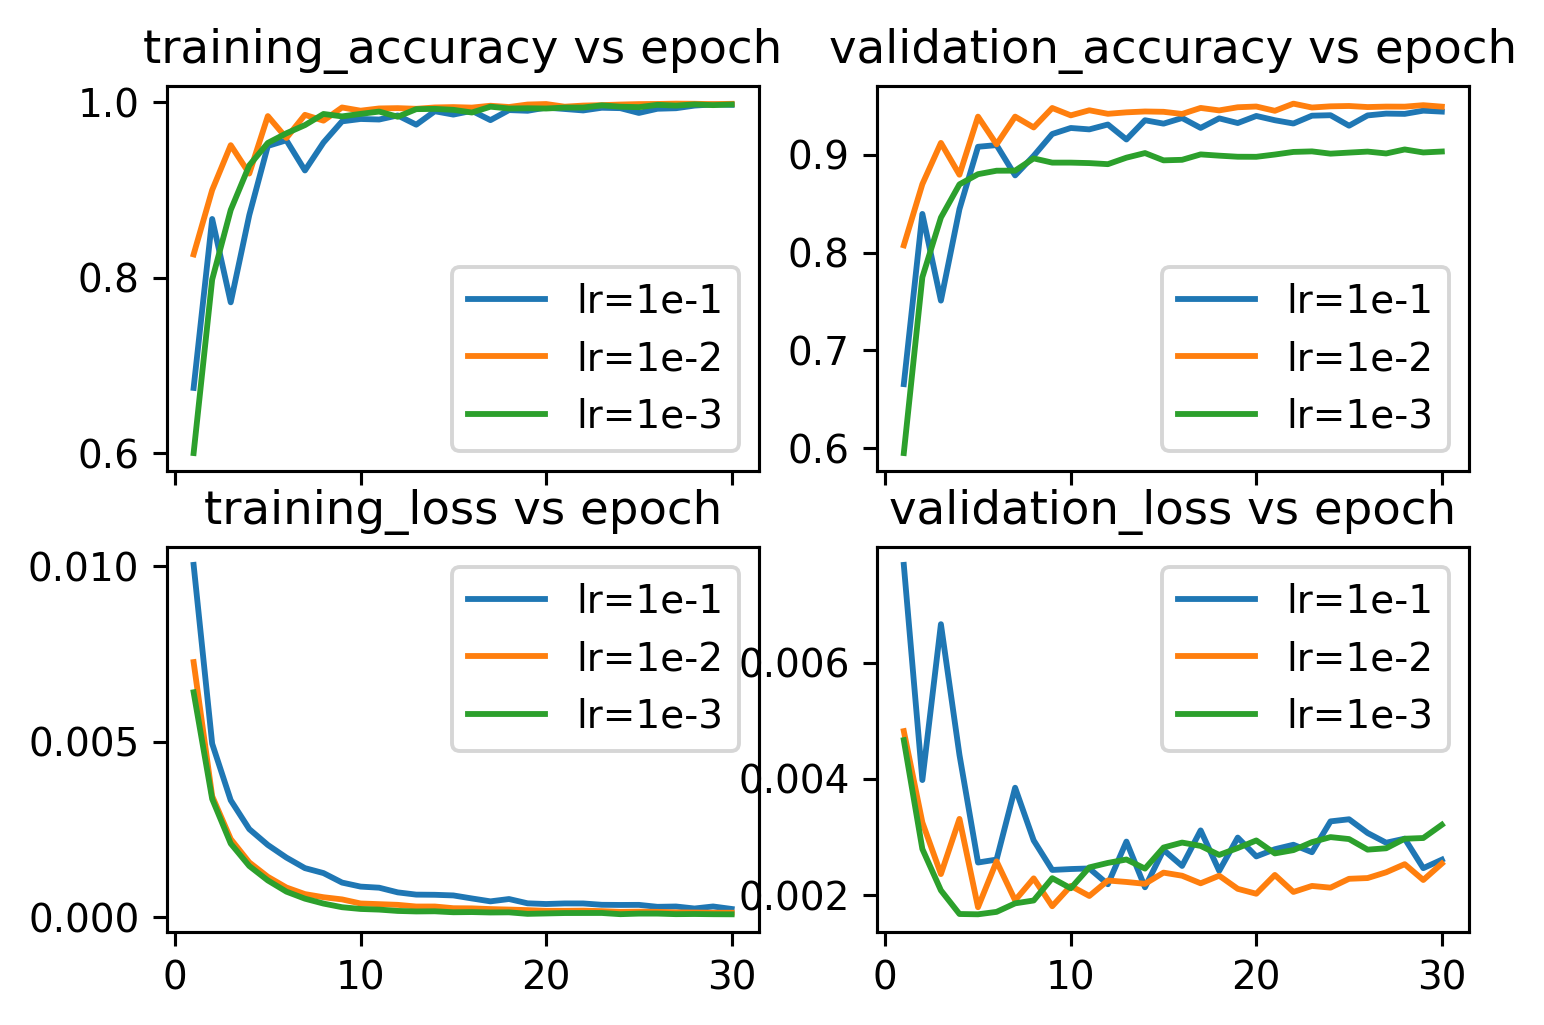

In [ ]:
#  visualising metrics
figure, axes = plt.subplots(2,2, dpi=280, sharex=True)
axes[0,0].set_title('training_accuracy vs epoch')
axes[0,1].set_title('validation_accuracy vs epoch')
axes[1,0].set_title('training_loss vs epoch')
axes[1,1].set_title('validation_loss vs epoch')
#axes[0].ylabel('accuracy')
#axes[1].set_title('loss vs epoch')
#axes[1].ylabel('loss')
#axes[1].xlabel('epoch')

sns.lineplot(x=metrics_75x75_bn1[:,0], y=metrics_75x75_bn1[:,2], label='lr=1e-1', ax=axes[0,0])
sns.lineplot(x=metrics_75x75_bn2[:,0], y=metrics_75x75_bn2[:,2], label='lr=1e-2', ax=axes[0,0])
sns.lineplot(x=metrics_75x75[:,0], y=metrics_75x75[:,2], label='lr=1e-3', ax=axes[0,0])

sns.lineplot(x=metrics_75x75_bn1[:,0], y=metrics_75x75_bn1[:,4], label='lr=1e-1', ax=axes[0,1])
sns.lineplot(x=metrics_75x75_bn2[:,0], y=metrics_75x75_bn2[:,4], label='lr=1e-2', ax=axes[0,1])
sns.lineplot(x=metrics_75x75[:,0], y=metrics_75x75[:,4], label='lr=1e-3', ax=axes[0,1])

sns.lineplot(x=metrics_75x75_bn1[:,0], y=metrics_75x75_bn1[:,1], label='lr=1e-1', ax=axes[1,0])
sns.lineplot(x=metrics_75x75_bn2[:,0], y=metrics_75x75_bn2[:,1], label='lr=1e-2', ax=axes[1,0])
sns.lineplot(x=metrics_75x75[:,0], y=metrics_75x75[:,1], label='lr=1e-3', ax=axes[1,0])

sns.lineplot(x=metrics_75x75_bn1[:,0], y=metrics_75x75_bn1[:,3], label='lr=1e-1', ax=axes[1,1])
sns.lineplot(x=metrics_75x75_bn2[:,0], y=metrics_75x75_bn2[:,3], label='lr=1e-2', ax=axes[1,1])
sns.lineplot(x=metrics_75x75[:,0], y=metrics_75x75[:,3], label='lr=1e-3', ax=axes[1,1])

In [ ]:
#  defining function to convert metric array to dataframe
def metric_to_df(path):
  """
  this function takes a specified path as argument, 
  loads in the .npy file at said path and converts 
  it into a pandas dataframe
  """
  metric_array = np.load(path, allow_pickle=True)
  df = pd.DataFrame({'epoch': metric_array[:,0], 
                     'training_loss': metric_array[:,1],
                     'training_accuracy': metric_array[:,2],
                     'validation_loss': metric_array[:,3],
                     'validation_accuracy': metric_array[:,4]})
  return df

In [ ]:
#  creating a dataframe of metrics
metrics_path_1 = 'gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType75x75_bn_30epochs_1e-2.npy'
metrics_path_2 = 'gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType100x100_bn_30epochs_1e-2.npy'

metrics_75 = metric_to_df(metrics_path_1)
metrics_100 = metric_to_df(metrics_path_2)

In [ ]:
#  deriving test accuracy
accuracy(model, test_dl, verbose=True)

  0%|          | 0/82 [00:00<?, ?it/s]

[7965/8133]
model predicts all instances to 97.93% accuracy


In [57]:
#  loading model states
model_100 = CarRecognition()
model_100.load_state_dict(torch.load('gdrive/My Drive/Neural Networks/Model_States/CarType100x100_model_state_completed.pt', map_location=device))

model_75 = CarRecognition_75()
model_75.load_state_dict(torch.load('gdrive/My Drive/Neural Networks/Model_States/CarType75x75_model_state_completed.pt', map_location=device))

model_100x = CarRecognition_bn()
model_100x.load_state_dict(torch.load('gdrive/My Drive/Neural Networks/Model_States/CarType100_model_state_1e-2_9ep.pt', map_location=device))

model_75x = CarRecognition_bn75()
model_75x.load_state_dict(torch.load('gdrive/My Drive/Neural Networks/Model_States/CarType75_model_state_1e-2_17ep.pt', map_location=device))

<All keys matched successfully>

In [50]:
#  defining visual test function
def visual_test(path, model_1, model_2,
                model_3=None, model_4=None, num_models=2):
  if num_models == 2:
    model_1.eval()
    model_2.eval()
    with torch.no_grad():
      vt_img = cv2.imread(path)
      vt_img = cv2.resize(vt_img, (75,75))
      vt_img_tensor = transforms.ToTensor()(vt_img)
      out = model_1(vt_img_tensor)
      output_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}
      probability = F.softmax(F.softmax(out, dim=1), dim=1)*100
      print('model 75x75px')
      print(f'sedan: {probability[0][0].round()}%, coupe: {probability[0][1].round()}%,' 
            +f' suv: {probability[0][2].round()}%, truck: {probability[0][3].round()}%')
      print(f'prediction: {output_dict[torch.argmax(out).item()]}')
      print('_'*55)

      vt_img = cv2.imread(path)
      vt_img = cv2.resize(vt_img, (100,100))
      plt.imshow(vt_img)
      vt_img_tensor = transforms.ToTensor()(vt_img)
      out = model_2(vt_img_tensor)
      output_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}
      probability_2 = F.softmax(F.softmax(out, dim=1), dim=1)*100
      print('model 100x100px')
      print(f'sedan: {probability_2[0][0].round()}%, coupe: {probability_2[0][1].round()}%,' 
            +f' suv: {probability_2[0][2].round()}%, truck: {probability_2[0][3].round()}%')
      print(f'prediction: {output_dict[torch.argmax(out).item()]}')
      print('_'*55)

      print('average class prediction')
      avg = np.array(([probability.numpy()], [probability_2.numpy()]))
      avg = avg.reshape(2,4)
      avg = avg.mean(axis=0)
      print(f'sedan: {avg[0].round()}%, coupe: {avg[1].round()}%,' 
            +f' suv: {avg[2].round()}%, truck: {avg[3].round()}%')
      print(f'prediction: {output_dict[np.argmax(avg)]}')
      print('_'*55)

      print('highest confidence')
      confidence =  torch.concat((probability, probability_2), dim=1)
      highest_conf = torch.argmax(confidence)
      out_hc_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck',
                    4:'sedan', 5:'coupe', 6:'suv', 7:'truck'}
      print(f'sedan: {confidence[0][0].round()}%, coupe: {confidence[0][1].round()}%,' 
            +f' suv: {confidence[0][2].round()}%, truck: {confidence[0][3].round()}%'
            +f'\nsedan: {confidence[0][4].round()}%, coupe: {confidence[0][5].round()}%,'
            +f' suv: {confidence[0][6].round()}%, truck: {confidence[0][7].round()}%')
      print(f'prediction: {out_hc_dict[highest_conf.item()]}') 

  elif num_models == 4:
    if model_3 and model_4 != None:

      model_1.eval()
      model_2.eval()
      model_3.eval()
      model_4.eval()

      with torch.no_grad():
        vt_img = cv2.imread(path)
        vt_img = cv2.resize(vt_img, (75,75))
        vt_img_tensor = transforms.ToTensor()(vt_img)
        out = model_1(vt_img_tensor)
        output_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}
        probability = F.softmax(F.softmax(out, dim=1), dim=1)*100
        print('model 75x75px')
        print(f'sedan: {probability[0][0].round()}%, coupe: {probability[0][1].round()}%,' 
              +f' suv: {probability[0][2].round()}%, truck: {probability[0][3].round()}%')
        print(f'prediction: {output_dict[torch.argmax(out).item()]}')
        print('_'*55)

        vt_img = cv2.imread(path)
        vt_img = cv2.resize(vt_img, (75,75))
        vt_img_tensor = transforms.ToTensor()(vt_img)
        out = model_3(vt_img_tensor)
        output_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}
        probability_2 = F.softmax(F.softmax(out, dim=1), dim=1)*100
        print('model 75x75px (improved)')
        print(f'sedan: {probability_2[0][0].round()}%, coupe: {probability_2[0][1].round()}%,' 
              +f' suv: {probability_2[0][2].round()}%, truck: {probability_2[0][3].round()}%')
        print(f'prediction: {output_dict[torch.argmax(out).item()]}')
        print('_'*55)

        vt_img = cv2.imread(path)
        vt_img = cv2.resize(vt_img, (100,100))
        plt.imshow(vt_img)
        vt_img_tensor = transforms.ToTensor()(vt_img)
        out = model_2(vt_img_tensor)
        output_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}
        probability_3 = F.softmax(F.softmax(out, dim=1), dim=1)*100
        print('model 100x100px')
        print(f'sedan: {probability_3[0][0].round()}%, coupe: {probability_3[0][1].round()}%,' 
              +f' suv: {probability_3[0][2].round()}%, truck: {probability_3[0][3].round()}%')
        print(f'prediction: {output_dict[torch.argmax(out).item()]}')
        print('_'*55)

        vt_img = cv2.imread(path)
        vt_img = cv2.resize(vt_img, (100,100))
        plt.imshow(vt_img)
        vt_img_tensor = transforms.ToTensor()(vt_img)
        out = model_4(vt_img_tensor)
        output_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}
        probability_4 = F.softmax(F.softmax(out, dim=1), dim=1)*100
        print('model 100x100px (improved)')
        print(f'sedan: {probability_4[0][0].round()}%, coupe: {probability_4[0][1].round()}%,' 
              +f' suv: {probability_4[0][2].round()}%, truck: {probability_4[0][3].round()}%')
        print(f'prediction: {output_dict[torch.argmax(out).item()]}')
        print('_'*55)

        print('average class prediction')
        avg = np.array(([probability.numpy()], [probability_2.numpy()],
                        [probability_3.numpy()], [probability_4.numpy()]))
        avg = avg.reshape(4,4)
        avg = avg.mean(axis=0)
        print(f'sedan: {avg[0].round()}%, coupe: {avg[1].round()}%,' 
              +f' suv: {avg[2].round()}%, truck: {avg[3].round()}%')
        print(f'prediction: {output_dict[np.argmax(avg)]}')
        print('_'*55)

        print('highest confidence')
        confidence =  torch.concat((probability, probability_2,
                                    probability_3, probability_4), dim=1)
        highest_conf = torch.argmax(confidence)
        out_hc_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck',
                      4:'sedan', 5:'coupe', 6:'suv', 7:'truck',
                      8:'sedan', 9:'coupe', 10:'suv', 11:'truck',
                      12:'sedan', 13:'coupe', 14:'suv', 15:'truck'}
        print(f'sedan: {confidence[0][0].round()}%, coupe: {confidence[0][1].round()}%,' 
              +f' suv: {confidence[0][2].round()}%, truck: {confidence[0][3].round()}%'
              +f'\nsedan: {confidence[0][4].round()}%, coupe: {confidence[0][5].round()}%,'
              +f' suv: {confidence[0][6].round()}%, truck: {confidence[0][7].round()}%'
              +f'\nsedan: {confidence[0][8].round()}%, coupe: {confidence[0][9].round()}%,'
              +f' suv: {confidence[0][10].round()}%, truck: {confidence[0][11].round()}%'
              +f'\nsedan: {confidence[0][12].round()}%, coupe: {confidence[0][13].round()}%,'
              +f' suv: {confidence[0][14].round()}%, truck: {confidence[0][15].round()}%')
        print(f'prediction: {out_hc_dict[highest_conf.item()]}')

model 75x75px
sedan: 18.0%, coupe: 47.0%, suv: 17.0%, truck: 17.0%
prediction: coupe
_______________________________________________________
model 75x75px (improved)
sedan: 18.0%, coupe: 47.0%, suv: 18.0%, truck: 18.0%
prediction: coupe
_______________________________________________________
model 100x100px
sedan: 18.0%, coupe: 47.0%, suv: 18.0%, truck: 18.0%
prediction: coupe
_______________________________________________________
model 100x100px (improved)
sedan: 48.0%, coupe: 18.0%, suv: 17.0%, truck: 17.0%
prediction: sedan
_______________________________________________________
average class prediction
sedan: 25.0%, coupe: 40.0%, suv: 18.0%, truck: 18.0%
prediction: coupe
_______________________________________________________
highest confidence
sedan: 18.0%, coupe: 47.0%, suv: 17.0%, truck: 17.0%
sedan: 18.0%, coupe: 47.0%, suv: 18.0%, truck: 18.0%
sedan: 18.0%, coupe: 47.0%, suv: 18.0%, truck: 18.0%
sedan: 48.0%, coupe: 18.0%, suv: 17.0%, truck: 17.0%
prediction: sedan


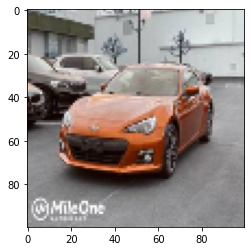

In [58]:
#  image path
path = 'gdrive/My Drive/Datasets/Car_Images/visual_test_images/cup_20.jpg'

#  performing visual test
visual_test(path, model_75, model_100,
            model_3=model_75x, model_4=model_100x, num_models=4)

In [ ]:
#  creating an object for test case
vt_img = cv2.imread(path)
vt_img = cv2.resize(vt_img, (100,100))
vt_img_tensor = transforms.ToTensor()(vt_img)

In [ ]:
#  creating object for background data
images, _ = next(iter(test_dl))

In [ ]:
#  instantiating explainer and deriving shap values
explainer = shap.DeepExplainer(model_100x, images[:100])
shap_values = explainer.shap_values(vt_img_tensor.view(-1,3,100,100))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
#  confirming predictions
torch.argmax(model_75(vt_img_tensor))

tensor(1)

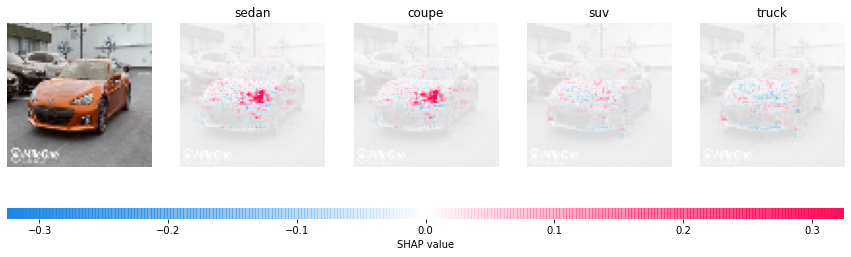

In [ ]:
#  model_75
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,75,75).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

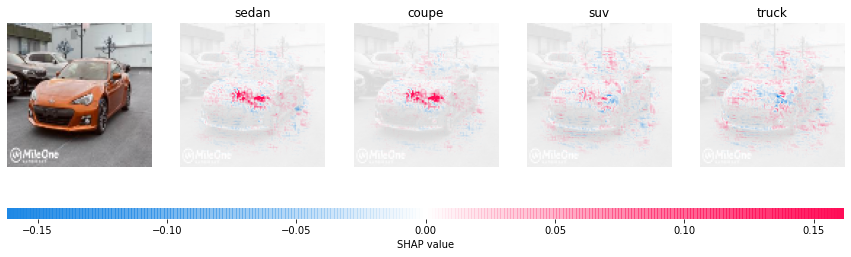

In [ ]:
#  model_100
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,100,100).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

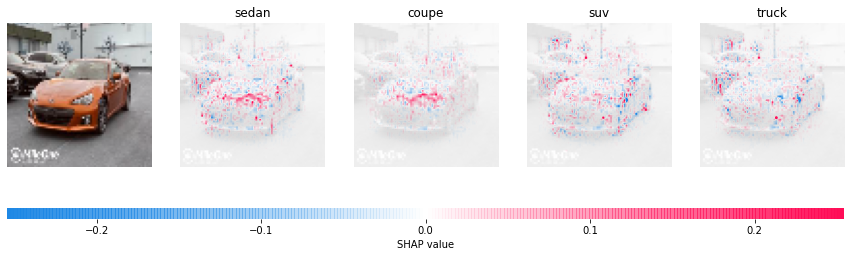

In [ ]:
#  model_75 (improved)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,75,75).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

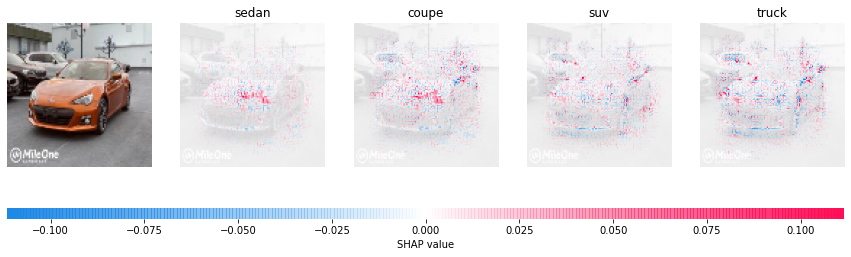

In [ ]:
#  model_100 (improved)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,100,100).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

model 75x75px
sedan: 17.0%, coupe: 17.0%, suv: 48.0%, truck: 17.0%
prediction: suv
_______________________________________________________
model 75x75px (improved)
sedan: 17.0%, coupe: 17.0%, suv: 48.0%, truck: 17.0%
prediction: suv
_______________________________________________________
model 100x100px
sedan: 18.0%, coupe: 17.0%, suv: 47.0%, truck: 17.0%
prediction: suv
_______________________________________________________
model 100x100px (improved)
sedan: 18.0%, coupe: 18.0%, suv: 47.0%, truck: 18.0%
prediction: suv
_______________________________________________________
average class prediction
sedan: 18.0%, coupe: 17.0%, suv: 47.0%, truck: 17.0%
prediction: suv
_______________________________________________________
highest confidence
sedan: 17.0%, coupe: 17.0%, suv: 48.0%, truck: 17.0%
sedan: 17.0%, coupe: 17.0%, suv: 48.0%, truck: 17.0%
sedan: 18.0%, coupe: 17.0%, suv: 47.0%, truck: 17.0%
sedan: 18.0%, coupe: 18.0%, suv: 47.0%, truck: 18.0%
prediction: suv


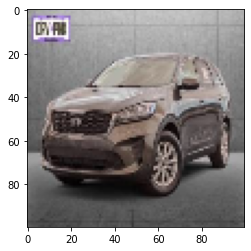

In [ ]:
#  performing visual test
visual_test(path, model_75, model_100,
            model_3=model_75x, model_4=model_100x, num_models=4)

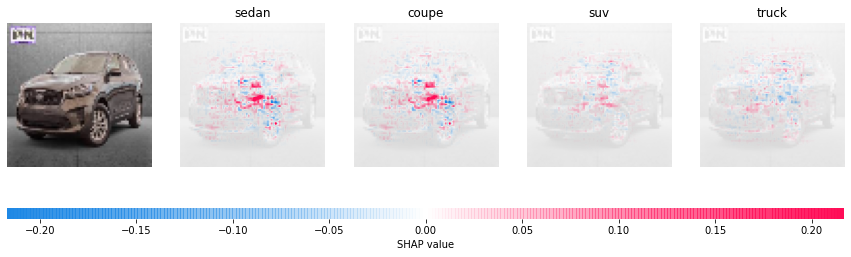

In [ ]:
#  model_75
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,75,75).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

In [ ]:
#  model_100
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,100,100).numpy(), 1, -1), 1, 2)

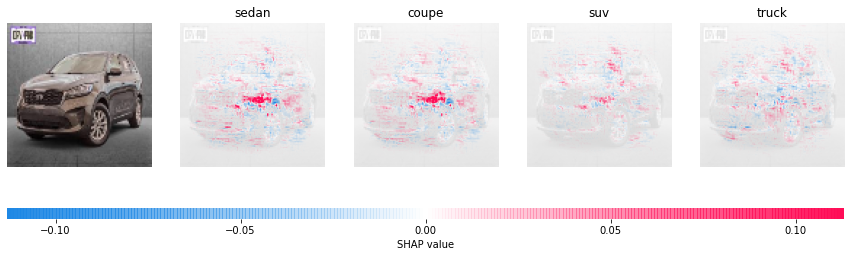

In [ ]:
shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

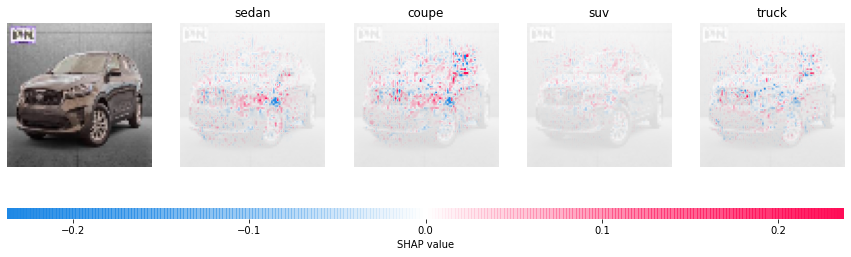

In [ ]:
#  model_75 (improved)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,75,75).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

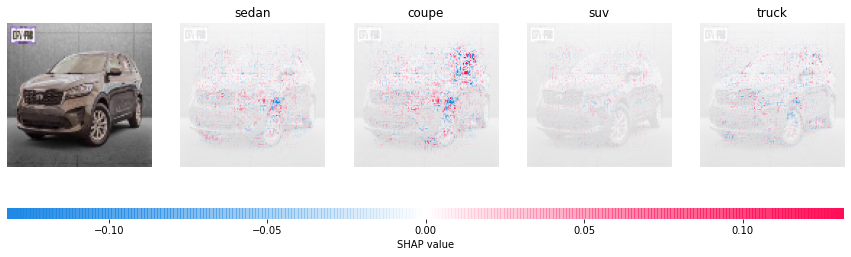

In [ ]:
#  model_100 (improved)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,100,100).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

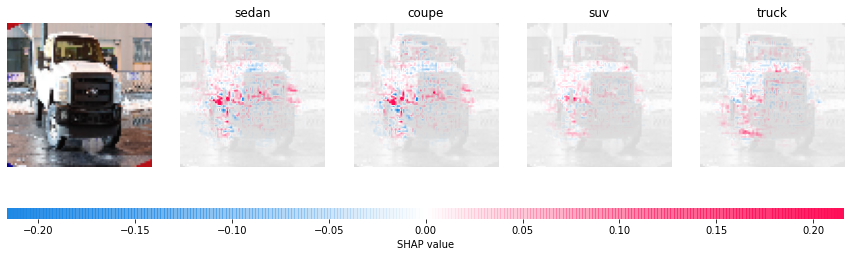

In [ ]:
#  model_75
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,75,75).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

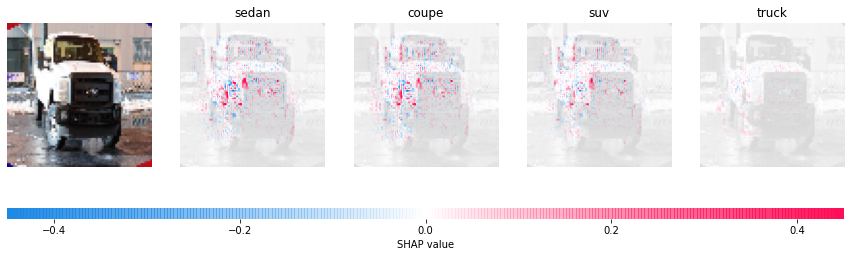

In [ ]:
#  model_75 (improved)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,75,75).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

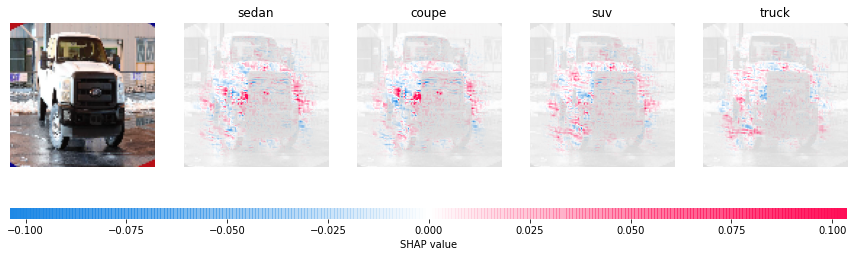

In [ ]:
#  model_100
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,100,100).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

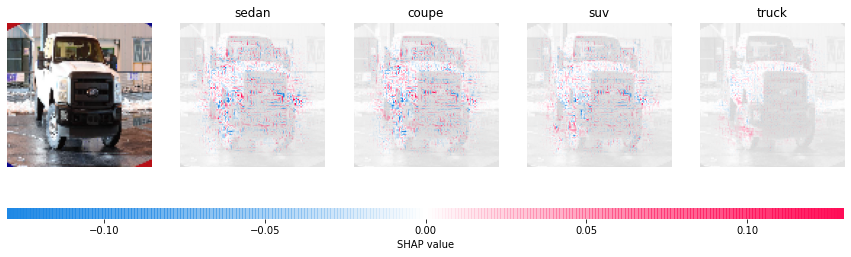

In [ ]:
#  model_100 (improved)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,100,100).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

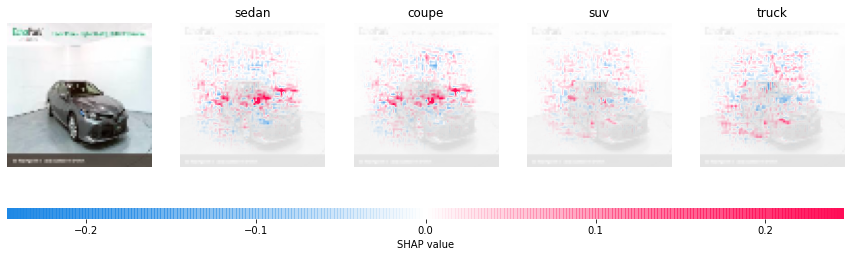

In [ ]:
#  model_75
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,75,75).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

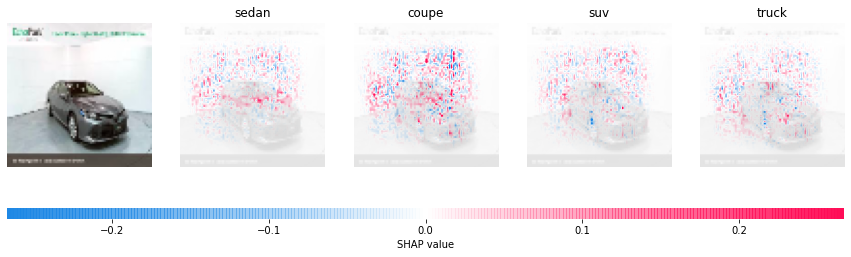

In [ ]:
#  model_75 (improved)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,75,75).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

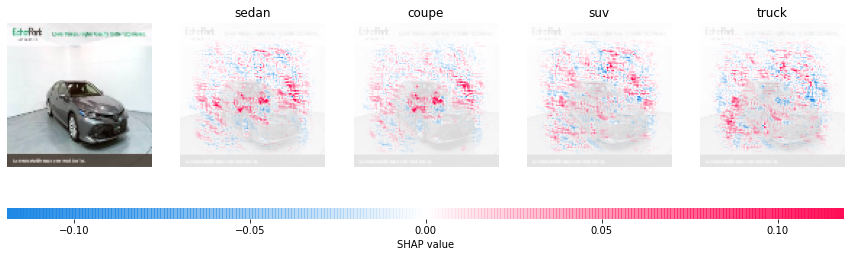

In [ ]:
#  model_100
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,100,100).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

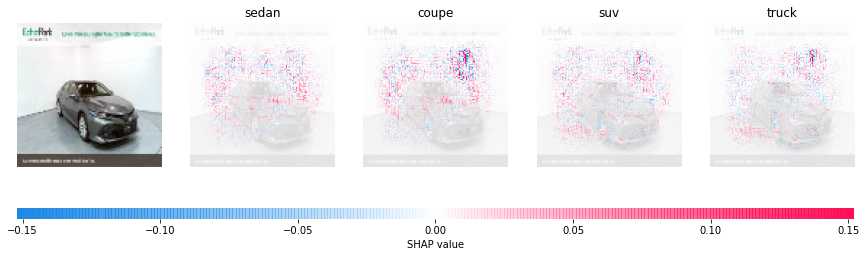

In [ ]:
#  model_100 (improved)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes
                         (vt_img_tensor.view(-1,3,100,100).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, 
                labels=['sedan', 'coupe', 'suv', 'truck'])

In [24]:
#  deriving accuracy 75px model
accuracy(model_75, test_75_dl, verbose=True)

  0%|          | 0/12 [00:00<?, ?it/s]

[2186/2374]
model predicts allinstances to 92.08% accuracy


In [25]:
#  deriving accuracy 75px (improved) model
accuracy(model_75x, test_75_dl, verbose=True)

  0%|          | 0/12 [00:00<?, ?it/s]

[2277/2374]
model predicts allinstances to 95.91% accuracy


In [26]:
#  deriving accuracy 100px model
accuracy(model_100, test_100_dl, verbose=True)

  0%|          | 0/12 [00:00<?, ?it/s]

[2179/2374]
model predicts allinstances to 91.79% accuracy


In [27]:
#  deriving accuracy 100px (improved) model
accuracy(model_100x, test_100_dl, verbose=True)

  0%|          | 0/12 [00:00<?, ?it/s]

[2281/2374]
model predicts allinstances to 96.08% accuracy


In [113]:
def extract_results(network, dataloader, file_name):
  #  creating an empty list
  results = []
  labels = []

  #  classification
  with torch.no_grad():
    for img, lb in tqdm(dataloader):
      img, lb = img.to(device), lb.to(device)
      preds = network(img)
      results.extend(torch.argmax(preds, dim=1).tolist())
      labels.extend(lb.tolist())

  df = pd.DataFrame({'predicted': results, 'labels': labels})
  df.to_csv(f'gdrive/My Drive/Neural Networks/Test_results/{file_name}', 
            index=False)
  print('\nDone!')
  return df.head()

def compare_accuracies(model_1, model_2, model_3, model_4, dl_1, dl_2, labels=[]):
  print('computing for model_1...')
  score_1 = accuracy(model_1, dl_1)*100
  print(f'accuracy = {round(score_1,2)}%')
  print('\ncomputing for model_2...')
  score_2 = accuracy(model_2, dl_1)*100
  print(f'accuracy = {round(score_2,2)}%')
  print('\ncomputing for model_3...')
  score_3 = accuracy(model_3, dl_2)*100
  print(f'accuracy = {round(score_3,2)}%')
  print('\ncomputing for model_4...')
  score_4 = accuracy(model_4, dl_2)*100
  print(f'accuracy = {round(score_4,2)}%\n')

  plt.figure(figsize=(8,7))
  return sns.barplot(x=labels, y=[score_1, score_2, score_3, score_4])

computing for model_1...


  0%|          | 0/12 [00:00<?, ?it/s]

accuracy = 92.08%

computing for model_2...


  0%|          | 0/12 [00:00<?, ?it/s]

accuracy = 95.91%

computing for model_3...


  0%|          | 0/12 [00:00<?, ?it/s]

accuracy = 91.79%

computing for model_4...


  0%|          | 0/12 [00:00<?, ?it/s]

accuracy = 96.08%



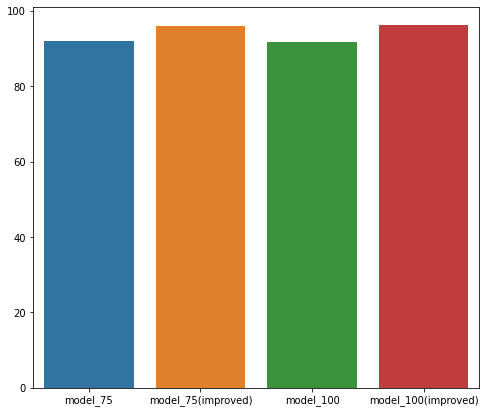

In [114]:
compare_accuracies(model_75, model_75x, model_100,
                   model_100x, test_75_dl, test_100_dl,
                   labels=['model_75', 'model_75(improved)',
                           'model_100', 'model_100(improved)'])

In [ ]:
#  extracting test results
extract_results(model_100, test_100_dl, 'CarType100_results.csv')

In [36]:
#  loading test results
test_75_results = pd.read_csv('gdrive/My Drive/Neural Networks/Test_results/CarType75_results.csv')
test_75x_results = pd.read_csv('gdrive/My Drive/Neural Networks/Test_results/CarType75(improved)_results.csv')
test_100_results = pd.read_csv('gdrive/My Drive/Neural Networks/Test_results/CarType100_results.csv')
test_100x_results = pd.read_csv('gdrive/My Drive/Neural Networks/Test_results/CarType100(improved)_results.csv')

In [63]:
#  defining mapping function
def actual_label(instance):
  if instance == 0:
    instance = 'sedan'
  elif instance == 1:
    instance = 'coupe'
  elif instance == 2:
    instance = 'suv'
  elif instance == 3:
    instance = 'truck'
  return instance

#  defining function to map function
def map_df(df, map_func):
  df['predicted'] = df['predicted'].map(map_func)
  df['labels'] = df['labels'].map(map_func)
  return df

#  defining function to filter misclassifications
def misclass_filter(df):
  return df[df['predicted']!=df['labels']]

#  defining summary function
def misclass_summary(df1, df2, df3, df4):
  summary = pd.DataFrame({'model_75px': df1['labels'].value_counts().sort_index().values,
                          'model_75px(improved)':df2['labels'].value_counts().sort_index().values,
                          'model_100px':df3['labels'].value_counts().sort_index().values,
                          'model_100px(improved)':df4['labels'].value_counts().sort_index().values},
                         index=df1['labels'].value_counts().sort_index().index)
  return summary

In [39]:
#  converting numerical labels into strings
test_75_results = map_df(test_75_results, actual_label)
test_75x_results = map_df(test_75x_results, actual_label)
test_100_results = map_df(test_100_results, actual_label)
test_100x_results = map_df(test_100x_results, actual_label)

In [41]:
#  previewing converted labels
test_75x_results.head()

predicted labels
0       suv    suv
1     truck  truck
2     sedan  sedan
3       suv    suv
4     coupe  coupe

In [43]:
#  filtering out misclassified instances
misclassified_75 = misclass_filter(test_75_results)
misclassified_75x = misclass_filter(test_75x_results)
misclassified_100 = misclass_filter(test_100_results)
misclassified_100x = misclass_filter(test_100x_results)

In [80]:
#  summarizing misclassifications
misclassification_summary = misclass_summary(misclassified_75, misclassified_75x,
                                            misclassified_100, misclassified_100x)

misclassification_summary

model_75px  model_75px(improved)  model_100px  model_100px(improved)
coupe          32                    28           16                     12
sedan          61                    24           86                     35
suv            73                    25           57                     36
truck          22                    20           36                     10

In [65]:
#  total misclassifications by model
results_summary.sum()

model_75px               188
model_75px(improved)      97
model_100px              195
model_100px(improved)     93
dtype: int64

In [77]:
def ensemble(model_1, model_2, dl_1, dl_2, mode, accuracy=False):
  if mode==1:
    #  setting model states
    model_1.eval()
    model_2.eval()
    #  creating counters for accuracy
    correct_instances = 0
    all_instances = 0
    actual_labels = []
    model_1_preds = []
    model_2_preds = []
    ensemble_preds = []

    with torch.no_grad():
      print('model_1...')
      for img_1, lb_1 in tqdm(dl_1):
        output_1 = model_1(img_1)
        output_1 = torch.argmax(output_1, dim=1)
        model_1_preds.extend(output_1)
        actual_labels.extend(lb_1)

      print('\nmodel_2...')
      for img_2, lb_2 in tqdm(dl_2):
        output_2 = model_2(img_2)
        output_2 = torch.argmax(output_2, dim=1)
        model_2_preds.extend(output_2)

      model_1_preds = torch.tensor(model_1_preds)
      model_2_preds = torch.tensor(model_2_preds)
      actual_labels = torch.tensor(actual_labels)
      output_3 = torch.ones_like(model_1_preds)

      print('\nensembling...')
      for i in tqdm(range(len(model_1_preds))):
        if model_1_preds[i].item() in [0, 2] and model_2_preds[i].item not in [1, 3]:
          output_3[i] = model_1_preds[i]
        else:
          output_3[i] = model_2_preds[i]
#  by this logic, the most accurate model (100px) is given priority if either model fails 
#  to predict its strong point(sedan and suv for 75px, coupe and truck for 100px)
      print('\ncomputing accuracy...')
      correct = sum(output_3==actual_labels)
      correct_instances+=correct.item()
      all_instances+=len(actual_labels)

      acc = (correct_instances/all_instances)*100
      print(f'[{correct_instances}/{all_instances}]\n{round(acc, 2)}%')
    print('Done!')

  if mode==2:
    #  setting model states
    model_1.eval()
    model_2.eval()
    #  creating counters for accuracy
    correct_instances = 0
    all_instances = 0
    actual_labels = []
    model_1_preds = []
    model_2_preds = []
    ensemble_preds = []

    with torch.no_grad():
      print('model_1...')
      for img_1, lb_1 in tqdm(dl_1):
        output_1 = model_1(img_1)
        model_1_preds.append(output_1)
        actual_labels.append(lb_1)

      print('\nmodel_2...')
      for img_2, lb_2 in tqdm(dl_2):
        output_2 = model_2(img_2)
        model_2_preds.append(output_2)

      print('\nensembling...')
      for i in tqdm(range(len(model_1_preds))):
        output_3 = torch.ones((2,model_1_preds[i].shape[0], 
                              model_1_preds[i].shape[1]))
        output_3[0] = model_1_preds[i]
        output_3[1] = model_2_preds[i]
        output_3 = output_3.mean(dim=0)
        output_3 = torch.argmax(output_3, dim=1)

        correct = sum(output_3==actual_labels[i])
        correct_instances+=correct.item()
        all_instances+=len(actual_labels[i])
    
    acc = correct_instances/all_instances*100
    print(f'\n\n[{correct_instances}/{all_instances}]\n{round(acc,2)}%')
    print('Done!')

In [178]:
ensemble(model_75x, model_100x,
         test_75_dlUS, test_100_dlUS, 2)

model_1...


100%|██████████| 12/12 [00:18<00:00,  1.57s/it]



model_2...


100%|██████████| 12/12 [00:36<00:00,  3.05s/it]



ensembling...


100%|██████████| 12/12 [00:00<00:00, 681.35it/s]



[2307/2374]
97.18%
Done!


Text(0.5, 0, 'accuracy (%)')

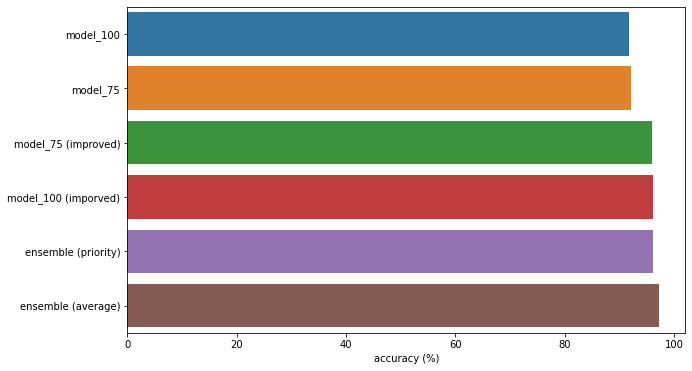

In [193]:
plt.figure(figsize=(10,6))
sns.barplot(y=['model_100', 'model_75', 'model_75 (improved)', 
               'model_100 (imporved)', 'ensemble (priority)', 'ensemble (average)'],
            x=[91.79, 92.08, 95.91, 96.08, 96.17, 97.18])
plt.xlabel('accuracy (%)')

In [174]:
#  defining ensemble class
class EnsembleModels():
  def __init__(self, model_1, model_2):
    self.model_1 = model_1
    self.model_2 = model_2

  def priority(self, image_path):
    with torch.no_grad():
      #  setting model states
      self.model_1.eval()
      self.model_2.eval()
      
      #  reading image from path
      image = cv2.imread(image_path)
      #  resizing image
      image_75 = cv2.resize(image, (75,75))
      image_100 = cv2.resize(image, (100,100))
      #  converting images to tensor
      image_75 = transforms.ToTensor()(image_75)
      image_100 = transforms.ToTensor()(image_100)

      #  making predictions
      output_1 = self.model_1(image_75)
      output_2 = self.model_2(image_100)

      #  deriving probabilities
      output_1p = F.softmax(F.softmax(output_1, dim=1), dim=1)*100
      output_2p = F.softmax(F.softmax(output_2, dim=1), dim=1)*100

      #  determining predicted class
      output_1x = torch.argmax(output_1, dim=1)
      output_2x = torch.argmax(output_2, dim=1)

      #  class dictionary
      class_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}

      #  priority logic
      if output_1x.item() in [0,2] and output_2x.item() not in [1,3]:
        output_3 = output_1x.item()
        print('model_75x')
        print(f'sedan: {output_1p[0][0].round()}% coupe: {output_1p[0][1].round()}%'+ 
              f' suv: {output_1p[0][2].round()}% truck: {output_1p[0][3].round()}%')
        print(f'prediction: {class_dict[output_3]}')
      else:
        output_3 = output_2x.item()
        print('model_100x')
        print(f'sedan: {output_2p[0][0].round()}% coupe: {output_2p[0][1].round()}%'+ 
              f' suv: {output_2p[0][2].round()}% truck: {output_2p[0][3].round()}%')
        print(f'prediction: {class_dict[output_3]}')

  def average_confidence(self, image_path):
    with torch.no_grad():
      #  setting model states
      self.model_1.eval()
      self.model_2.eval()
      
      #  reading image from path
      image = cv2.imread(image_path)
      #  resizing image
      image_75 = cv2.resize(image, (75,75))
      image_100 = cv2.resize(image, (100,100))
      #  converting images to tensor
      image_75 = transforms.ToTensor()(image_75)
      image_100 = transforms.ToTensor()(image_100)

      #  making predictions
      output_1 = self.model_1(image_75)
      output_2 = self.model_2(image_100)

      #  creating placeholder tensor
      placeholder = torch.ones((2,4))
      #  inputing tensors
      placeholder[0] = output_1
      placeholder[1] = output_2 

      #  computing average
      output_3 = placeholder.mean(dim=0)

      #  deriving probabilities
      output_3p = F.softmax(F.softmax(output_3, dim=0), dim=0)*100

      #  deriving predicted class
      idx_p = torch.argmax(output_3, dim=0)

      #  class dictionary
      class_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}

      #  printing to screen
      print(f'sedan: {output_3p[0].round()}% coupe: {output_3p[1].round()}%'+ 
          f' suv: {output_3p[2].round()}% truck: {output_3p[3].round()}%')
      print(f'prediction: {class_dict[idx_p.item()]}')

In [176]:
path = 'gdrive/My Drive/Datasets/Car_Images/visual_test_images/sv_8.jpg'

model_ex = EnsembleModels(model_75x, model_100x)
model_ex.average_confidence(path)

sedan: 17.0% coupe: 17.0% suv: 48.0% truck: 17.0%
prediction: suv


In [177]:
model_ex.priority(path)

model_75x
sedan: 17.0% coupe: 17.0% suv: 48.0% truck: 17.0%
prediction: suv


model 75x75px
sedan: 17.0%, coupe: 48.0%, suv: 17.0%, truck: 17.0%
prediction: coupe
_______________________________________________________
model 100x100px
sedan: 41.0%, coupe: 22.0%, suv: 18.0%, truck: 18.0%
prediction: sedan
_______________________________________________________
average class prediction
sedan: 29.0%, coupe: 35.0%, suv: 18.0%, truck: 18.0%
prediction: coupe
_______________________________________________________
highest confidence
sedan: 17.0%, coupe: 48.0%, suv: 17.0%, truck: 17.0%
sedan: 41.0%, coupe: 22.0%, suv: 18.0%, truck: 18.0%
prediction: coupe


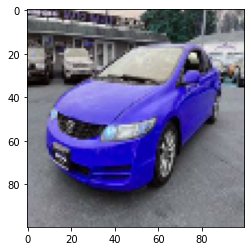

In [99]:
#  performing visual test
visual_test('gdrive/My Drive/Datasets/Car_Images/visual_test_images/cup_2.jpg', 
            model_75x, model_100x)

In [182]:
accuracy(model_75x, test_75_dl, verbose=True)

  0%|          | 0/12 [00:00<?, ?it/s]

[2277/2374]
model predicts allinstances to 95.91% accuracy
